In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import networkx as nx
from nanonets import Simulation
from nanonets.utils import BLUE_COLOR, RED_COLOR
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.linalg import eig

plt.style.use(["science","bright","grid"])

CPU_CNT     = 32
N_VOLT      = 50000
TIME_STEP   = 1e-11
R_VALUES    = [50,100,200,400,800,1600]
PLOT_NORM_R = Normalize(vmin=R_VALUES[0], vmax=R_VALUES[-1])
CMAP        = plt.get_cmap('cividis')
U0_VALUE    = 0.02
N_P         = 9
N_J_TOTAL   = 2*N_P*(N_P-1)
MARKERS     = ['o','s','<','>','^']
# FOLDER      = "/home/j/j_mens07/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/res_disorder/"
# FOLDER      = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/DC/res_disorder/"
FOLDER      = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/res_disorder/"

def tau_exp_fit(t, y, min_range=0.05, kohlrausch=True):
    signal_range = np.max(y) - np.min(y)
    if signal_range < min_range:
        return np.nan
    
    t_ns    = t * 1e9
    y_start = y[0]
    y_end   = np.median(y[int(len(y)*0.9):])
    A_fixed = y_end - y_start
    th_val  = y_start + 0.632 * A_fixed

    if A_fixed > 0:
        cross_idx = np.where(y > th_val)[0]
    else:
        cross_idx = np.where(y < th_val)[0]

    if len(cross_idx) > 0:
        guess_tau = t_ns[cross_idx[0]]
    else:
        guess_tau = 0.1

    if kohlrausch:
        def relaxation_model(t_vals, tau, beta):
            return y_start + A_fixed * (1 - np.exp(-(t_vals / tau)**beta))
        p0 = [guess_tau, 1.0]
        bounds = ([1e-6, 0.1], [np.inf, 1.0])
    else:
        def relaxation_model(t_vals, tau):
            return y_start + A_fixed * (1 - np.exp(-t_vals / tau))
        p0 = [guess_tau]
        bounds = (1e-6, np.inf)

    try:
        popt, pcov = curve_fit(relaxation_model, t_ns, y, p0=p0, bounds=bounds)
        
        # Calculate R-squared
        residuals = y - relaxation_model(t_ns, *popt)
        r_squared = 1 - (np.sum(residuals**2) / np.sum((y - np.mean(y))**2))
        
        # Calculate standard errors
        perr = np.sqrt(np.diag(pcov))
        
        # Define failure criteria
        # 1. Very poor correlation
        # 2. Fit hit the lower bound of tau (meaning it's too fast to measure)
        # 3. Tau error is larger than the value (complete uncertainty)
        is_bad = (r_squared < 0.7 or 
                np.isclose(popt[0], 1e-6, atol=1e-7) or 
                perr[0] > popt[0])

        if kohlrausch:
            # For beta, we care if it's hitting the floor (0.1) 
            # or if the error is so massive that beta is meaningless
            if perr[1] > 1.0 or np.isclose(popt[1], 0.1, atol=0.01):
                is_bad = True
                
        if is_bad:
            return np.nan, np.nan

        # Calculate final tau
        if kohlrausch:
            tau_k, beta = popt
            tau_fit = (tau_k / beta) * gamma(1 / beta)
        else:
            tau_fit = popt[0]
            beta = 1.0 # Default beta for single exponential

        return tau_fit * 1e-9, beta

    except (RuntimeError, ValueError, ZeroDivisionError):
        return np.nan, np.nan

### Load Average Potential Data

In [3]:
t       = np.arange(N_VOLT) * TIME_STEP
# p_vals  = {MEAN_R2 : [pd.read_csv(f"{FOLDER}mean_state_Nx={N_P}_Ny={N_P}_Ne=8_mean2_{MEAN_R2}_{i}.csv").iloc[:,8:].values 
#                         for i in range(CPU_CNT)] for MEAN_R2 in R_VALUES}
p_avg   = {MEAN_R2 : [np.mean(pd.read_csv(f"{FOLDER}mean_state_Nx={N_P}_Ny={N_P}_Ne=8_mean2_{MEAN_R2}_{i}.csv").iloc[:,8:].values, axis=1) for i in range(CPU_CNT)] for MEAN_R2 in R_VALUES}
# p_avg   = {MEAN_R2 : [np.mean(p_vals[MEAN_R2][i], axis=1) for i in range(CPU_CNT)] for MEAN_R2 in R_VALUES}
# y_vals  = {MEAN_R2 : [pd.read_csv(f"{FOLDER}Nx={N_P}_Ny={N_P}_Ne=8_mean2_{MEAN_R2}_{i}.csv").loc[:,'Observable'].values 
#                         for i in range(CPU_CNT)] for MEAN_R2 in R_VALUES}

### RC Time Constant

In [4]:
tau_t = {}
for MEAN_R2 in R_VALUES:
    tau_t_l     = []
    res_info2   = {'N':N_J_TOTAL//3, 'mean_R':MEAN_R2, 'std_R':0.0}
    for i in range(CPU_CNT):
        topo = {"Nx": N_P,"Ny": N_P,
                        "e_pos": [[(N_P-1)//2, 0],[0, 0],[N_P-1, 0],
                                [0, (N_P-1)//2],[N_P-1, (N_P-1)//2],
                                [0, N_P-1],[N_P-1, N_P-1],[(N_P-1)//2, N_P-1]],
                        "electrode_type": ['constant']*8}
        sim_c   = Simulation(topo, seed=i, res_info2=res_info2)
        sim_c.build_conductance_matrix()
        cap_m           = sim_c.get_capacitance_matrix()*1e-18
        g_m             = sim_c.get_conductance_matrix()[:-8,:-8]
        eigenvalues, _  = eig(g_m, cap_m)
        real_eigs       = np.real(eigenvalues)
        valid_eigs      = real_eigs[real_eigs > 1e-9]
        lambda_min      = np.min(valid_eigs)
        tau_t_l.append(1.0 / lambda_min)
    tau_t[MEAN_R2] = tau_t_l
df_taus_t           = pd.DataFrame(tau_t)*1e9
df_taus_t.columns   = R_VALUES
df_taus_t['Type']   = '$\\tau_0$'
df_taus_t.head()

,50,100,200,400,800,1600,Type
0,4.042302,5.258142,6.991133,9.273136,11.922206,18.611287,$\tau_0$
1,3.877868,4.956339,6.623981,8.886881,12.062466,22.113700,$\tau_0$
2,3.805405,4.680217,6.228277,8.726023,12.208351,21.934758,$\tau_0$
3,4.031063,5.290445,7.023739,9.486242,15.364476,29.262853,$\tau_0$
4,3.885222,4.807061,6.015660,7.355621,10.699304,20.244644,$\tau_0$


In [ ]:
df_taus_t

,50,100,200,400,800,1600,Type
0,4.042302,5.258142,6.991133,9.273136,11.922206,18.611287,$\tau_0$
1,3.877868,4.956339,6.623981,8.886881,12.062466,22.113700,$\tau_0$
2,3.805405,4.680217,6.228277,8.726023,12.208351,21.934758,$\tau_0$
3,4.031063,5.290445,7.023739,9.486242,15.364476,29.262853,$\tau_0$
4,3.885222,4.807061,6.015660,7.355621,10.699304,20.244644,$\tau_0$
5,3.956387,4.943392,6.412910,8.676833,11.599182,19.966765,$\tau_0$
6,3.984946,5.120468,6.701557,8.846986,11.556458,20.514356,$\tau_0$
7,3.887766,4.944717,6.698510,9.374261,12.655626,20.652414,$\tau_0$
8,4.108576,5.723527,8.465081,12.711152,18.615943,31.180229,$\tau_0$
9,3.841516,4.667593,5.811852,8.423658,15.138174,29.189936,$\tau_0$


### Average Time Constant

In [ ]:
df1         = delta_G_df.rename(columns={r : k for r, k in zip([25]+R_VALS, kappas)}).melt(var_name='k', value_name='G_max')
df2         = f_at_max_gain_df.rename(columns={r : k for r, k in zip([25]+R_VALS, kappas)}).melt(var_name='k', value_name='f')
df1['f']    = df2['f']

In [11]:
kohlrausch  = True
taus_d      = {}
betas_d     = {}
for MEAN_R2 in R_VALUES:
    taus    = []
    betas   = []
    for i in range(CPU_CNT):
        t_copy      = t.copy()[:-1]
        y_copy      = (p_avg[MEAN_R2][i].copy())/U0_VALUE
        tau, beta   = tau_exp_fit(t_copy, y_copy, kohlrausch=kohlrausch)
        taus.append(tau*1e9)
        betas.append(beta)
    taus_d[MEAN_R2]     = taus
    betas_d[MEAN_R2]    = betas
df_taus         = pd.DataFrame(taus_d)
df_taus.columns = R_VALUES
df_taus['Type'] = '$\\langle \\tau \\rangle$'
df_taus         = pd.concat([df_taus, df_taus_t], ignore_index=True)
df_tau_melted   = df_taus.melt(id_vars='Type', var_name='$R_2$ [M$\Omega$]', value_name='t')
df_uni_res      = pd.DataFrame([['$\\langle \\tau \\rangle$','$\\tau_0$'],[25,25],[4.3696610612686255, 3.1943502805261783]], index=['Type','$R_2$ [M$\Omega$]','t']).T

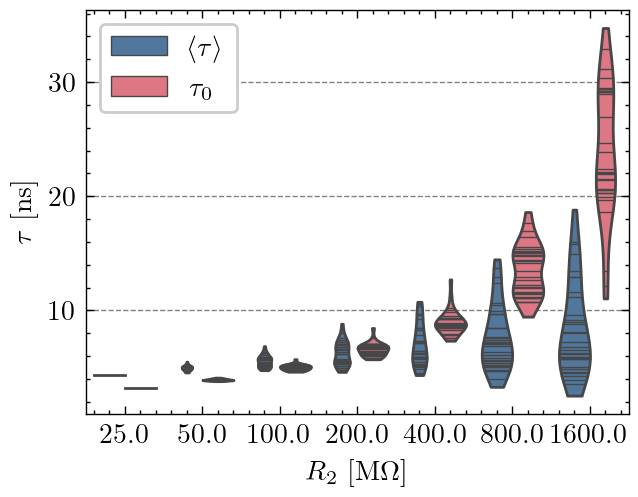

In [15]:
df                      = pd.concat([df_tau_melted,df_uni_res],ignore_index=True)
df['$R_2$ [M$\Omega$]'] = df['$R_2$ [M$\Omega$]'].astype('float')
df['t']                 = df['t'].astype('float')

fig, ax = plt.subplots(dpi=200)
ax      = sns.violinplot(df, x='$R_2$ [M$\Omega$]', y='t', hue='Type', density_norm='width', inner='stick', cut=0)
_       = ax.legend(title='')
_       = ax.set_ylabel("$\\tau$ [ns]")

fig.savefig(f"plots/png/relaxation/tau_vs_R2.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/tau_vs_R2.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/tau_vs_R2.svg", transparent=True)

In [39]:
df1     = df_taus[df_taus['Type']=='$\\langle \\tau \\rangle$'].drop(columns='Type').copy()
df1[25] = 4.3696610612686255
df1     = df1.loc[:,[25]+R_VALUES]
df1

,25,50,100,200,400,800,1600
0,4.369661,4.691282,4.908226,5.569597,5.340558,4.673830,4.287065
1,4.369661,4.781192,5.270015,5.710424,7.253406,7.400782,9.022100
2,4.369661,4.859652,5.022288,5.509415,6.146706,7.182687,8.821105
3,4.369661,4.567568,5.053514,4.996153,5.022381,4.794694,5.011146
4,4.369661,5.235981,5.819647,7.056475,9.265108,9.670593,11.168274
5,4.369661,5.070056,5.222761,5.495060,5.520483,5.618405,5.722071
6,4.369661,4.989189,5.475284,6.173108,6.488352,6.369276,6.176330
7,4.369661,4.787575,4.863619,5.121724,4.854886,5.068467,4.644416
8,4.369661,5.058526,5.787139,6.793233,8.438352,9.654301,12.892545
9,4.369661,5.164547,5.888183,6.549787,7.111340,8.459606,9.604865


In [21]:
df1 = df[df['Type']=='$\\langle \\tau \\rangle$'].drop(columns='Type').copy()

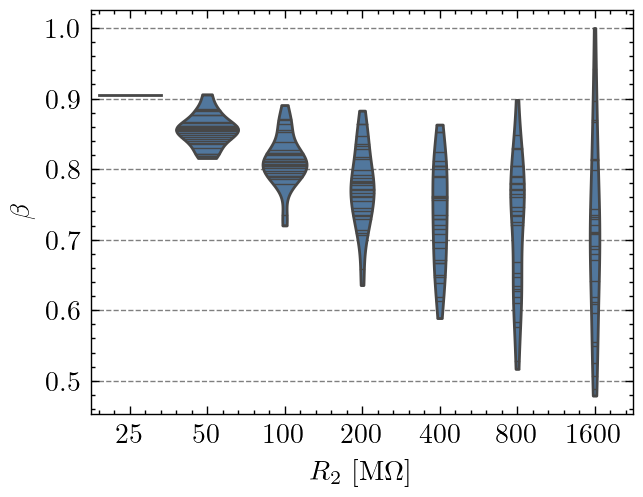

In [36]:
df      = pd.DataFrame(betas_d)
df.insert(0, 25, 0.9049540095671246)

fig, ax = plt.subplots(dpi=200)
ax      = sns.violinplot(df, density_norm='width', inner='stick', cut=0, color='#4477AA')
_       = ax.set_xlabel("$R_2$ [M$\Omega$]")
_       = ax.set_ylabel("$\\beta$")

fig.savefig(f"plots/png/relaxation/beta_vs_R2.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/beta_vs_R2.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/beta_vs_R2.svg", transparent=True)

In [43]:
df2 = df.copy()

In [44]:
df1     = df_taus[df_taus['Type']=='$\\langle \\tau \\rangle$'].drop(columns='Type').copy()
df1[25] = 4.3696610612686255
df1     = df1.loc[:,[25]+R_VALUES]
df2     = pd.DataFrame(betas_d)
df2.insert(0, 25, 0.9049540095671246)

kappas          = [1,2,4,8,16,32,64]
df1             = df1.rename(columns={r : k for r, k in zip([25]+R_VALUES, kappas)}).melt(var_name='k', value_name='tau')
df2             = df2.rename(columns={r : k for r, k in zip([25]+R_VALUES, kappas)}).melt(var_name='k', value_name='beta')
df1['beta']     = df2['beta']

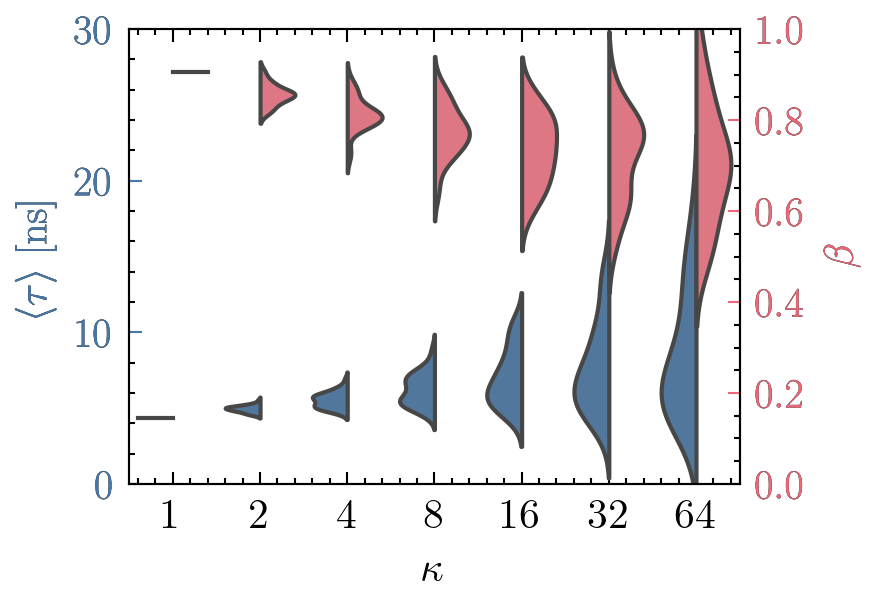

In [52]:
import matplotlib.patheffects as pe

fig, ax0  = plt.subplots(dpi=300)

w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

ax1     = ax0.twinx()
order   = ['tau','beta']
for ax, var_name in zip([ax0,ax1],order):
    sns.violinplot(df1.assign(var=var_name), x='k', y=var_name, hue='var', hue_order=order, ax=ax, split=True, inner=None, scale='width')
_   = ax0.set_xlabel("$\\kappa$")
l0  = ax0.set_ylabel("$\\langle \\tau \\rangle~[\mathrm{ns}]$",color=BLUE_COLOR)
l1  = ax1.set_ylabel("$\\beta$",color=RED_COLOR)
l0.set_path_effects([pe.Stroke(linewidth=0.1, foreground='black'),pe.Normal()])
l1.set_path_effects([pe.Stroke(linewidth=0.1, foreground='black'),pe.Normal()])

_   = ax0.set_ylim(0,30)
_   = ax1.set_ylim(0,1)
ax0.grid(False)
ax1.grid(False)
ax0.get_legend().remove()
ax1.get_legend().remove()
ax0.tick_params(axis='y', colors=BLUE_COLOR)
ax1.tick_params(axis='y', colors=RED_COLOR)

for lbl in ax0.get_yticklabels():
    lbl.set_path_effects([pe.Stroke(linewidth=0.1, foreground='black'),pe.Normal()])
for lbl in ax1.get_yticklabels():
    lbl.set_path_effects([pe.Stroke(linewidth=0.1, foreground='black'),pe.Normal()])


fig.savefig(f"plots/pdf/tau_and_beta_vs_kappa.pdf", transparent=False)
fig.savefig(f"plots/svg/tau_and_beta_vs_kappa.svg", transparent=True)
fig.savefig(f"plots/png/tau_and_beta_vs_kappa.png", transparent=False)

In [11]:
print(f"Minimum Beta Network: {np.argmin(betas_d[1600])} @ beta = {np.min(betas_d[1600])}")
print(f"Median Beta Network: {np.argsort(betas_d[1600])[16]} @ beta = {np.sort(betas_d[1600])[16]}")
print(f"Maximum Beta Network: {np.argsort(betas_d[1600])[-2]} @ beta = {np.sort(betas_d[1600])[-2]}")

Minimum Beta Network: 15 @ beta = 0.4790168665344114
Median Beta Network: 30 @ beta = 0.7094617433547837
Maximum Beta Network: 20 @ beta = 0.942152073714087


### Autocorrelation

In [12]:
def analyze_steady_state_autocorrelation(time, signal, start_idx=-20000):
        
    # 1. Slice the Steady State
    t_ss = time[start_idx:]
    y_ss = signal[start_idx:]
    
    # 2. Pre-processing
    dt = t_ss[1] - t_ss[0]
    y_fluctuation = y_ss - np.mean(y_ss)
    
    # 3. Compute Autocorrelation
    ft = np.fft.fft(y_fluctuation)
    acf = np.fft.ifft(ft * np.conjugate(ft)).real
    acf = acf[:len(acf)//2]
    
    # Normalize
    if acf[0] != 0:
        acf /= acf[0]
    
    lags = np.arange(len(acf)) * dt
    
    # 4. Fit Exponential Decay to extract tau_corr
    # We fit only the initial decay (e.g., until correlation drops to 1/e) to avoid fitting the noisy long-tail.
    def exp_decay(t, tau):
        return np.exp(-t / tau)
    
    # Find index where correlation drops below 0.1 (or 1/e) to limit fit range
    # If it never drops (infinite correlation), handle gracefully
    try:
        cutoff_idx = np.where(acf < 1/np.e)[0][0]
    except IndexError:
        cutoff_idx = len(acf) // 10 # Fallback
        
    # Ensure we have enough points to fit
    if cutoff_idx < 5: 
        cutoff_idx = 10 
        
    try:
        popt, _ = curve_fit(exp_decay, lags[:cutoff_idx], acf[:cutoff_idx], p0=[dt*10])
        # popt, _ = curve_fit(exp_decay, lags, acf, p0=[dt*10])
        tau_corr = popt[0]
    except:
        tau_corr = np.nan
        
    return tau_corr, lags, acf

def get_tau_1_over_e(lags, acf):
    """
    Finds the characteristic time where ACF drops to 1/e using linear interpolation.
    """
    threshold = 1.0 / np.e
    
    # Check if it drops immediately (uncorrelated noise)
    if acf[1] < threshold:
        return 0.0 # or lags[1] / 2
        
    # Check if it never drops (infinite memory / DC offset problem)
    if np.all(acf > threshold):
        return np.nan 
    
    # Find the index where it first crosses
    # np.where returns indices where condition is true. We take the first one.
    idx = np.where(acf < threshold)[0][0]
    
    # Linear Interpolation for precision
    # Points: (t1, y1) just above, (t2, y2) just below
    t1, y1 = lags[idx-1], acf[idx-1]
    t2, y2 = lags[idx],   acf[idx]
    
    # Formula: t = t1 + (threshold - y1) * (t2 - t1) / (y2 - y1)
    tau_interpolated = t1 + (threshold - y1) * (t2 - t1) / (y2 - y1)
    
    return tau_interpolated

def tau_exp_fit(t, y):
        
    t_ns    = t * 1e9
    y_start = y[0]
    y_end   = np.median(y[int(len(y)*0.9):])
    A_fixed = y_end - y_start
    th_val  = y_start + 0.632 * A_fixed

    if A_fixed > 0:
        cross_idx = np.where(y > th_val)[0]
    else:
        cross_idx = np.where(y < th_val)[0]

    if len(cross_idx) > 0:
        guess_tau = t_ns[cross_idx[0]]
    else:
        guess_tau = 0.1
    
    def relaxation_model(t_vals, tau):
        return y_start + A_fixed * (1 - np.exp(-t_vals / tau))
    
    try:
        popt, pcov = curve_fit(relaxation_model, t_ns, y, p0=[guess_tau], bounds=(1e-6,np.inf))
        tau_fit = popt[0]
        return tau_fit * 1e-9
    except RuntimeError:
        return np.nan

### Current

In [16]:
taus_acf = {}
for MEAN_R2 in R_VALUES:
    taus_acf[MEAN_R2] = []
    for i in range(CPU_CNT):
        t_copy          = t.copy()[:-1]
        y_copy          = y_vals[MEAN_R2][i]
        _ , lags, acf   = analyze_steady_state_autocorrelation(t_copy, y_copy, -20000)
        tau             = get_tau_1_over_e(lags, acf)
        
        taus_acf[MEAN_R2].append(tau*1e9)

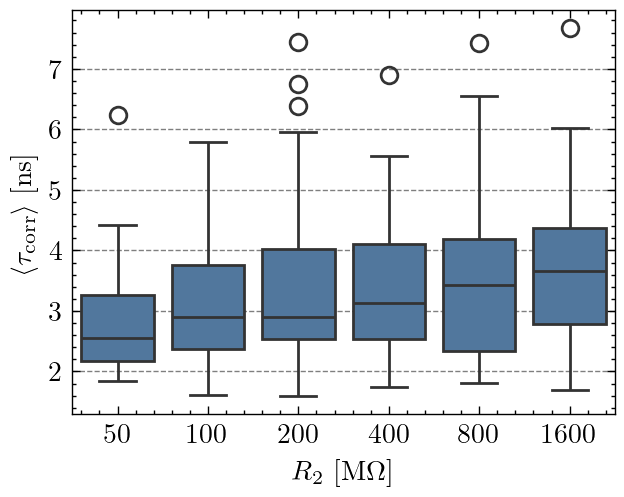

In [18]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.boxplot(taus_acf, color=BLUE_COLOR)
_       = ax.set_xlabel("$R_2$ [M$\Omega$]")
_       = ax.set_ylabel("$\\langle\\tau_\\textrm{corr}\\rangle$ [ns]")

fig.savefig(f"plots/png/relaxation/I_auto_tau_vs_R2.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/I_auto_tau_vs_R2.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/I_auto_tau_vs_R2.svg", transparent=True)

### Charges

In [35]:
taus_acf = {}
for MEAN_R2 in R_VALUES:
    taus_acf_l  = []
    for i in range(CPU_CNT):
        t_copy      = t.copy()[:-1]
        taus_acf_l2 = []
        y_tmp       = p_vals[MEAN_R2][i].copy()@cap_m
        for j in range(N_P*N_P):
            y_copy          = y_tmp[:,j]
            _ , lags, acf   = analyze_steady_state_autocorrelation(t_copy, y_copy, -20000)
            tau             = get_tau_1_over_e(lags, acf)
            taus_acf_l2.append(tau*1e9)
        taus_acf_l.append(taus_acf_l2)
    taus_acf[MEAN_R2] = np.array(taus_acf_l)

taus_acf_dic = {MEAN_R2 : taus_acf[MEAN_R2].flatten() for MEAN_R2 in R_VALUES}
taus_acf_df = pd.DataFrame()
for MEAN_R2 in R_VALUES:
    df_tmp          = pd.DataFrame()
    df_tmp['tau']   = taus_acf_dic[MEAN_R2]
    df_tmp['R2']    = MEAN_R2
    taus_acf_df     = pd.concat([taus_acf_df, df_tmp], ignore_index=True)

/tmp/ipykernel_29459/1314391583.py:25: RuntimeWarning: overflow encountered in exp
  return np.exp(-t / tau)
/tmp/ipykernel_29459/1314391583.py:39: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exp_decay, lags[:cutoff_idx], acf[:cutoff_idx], p0=[dt*10])


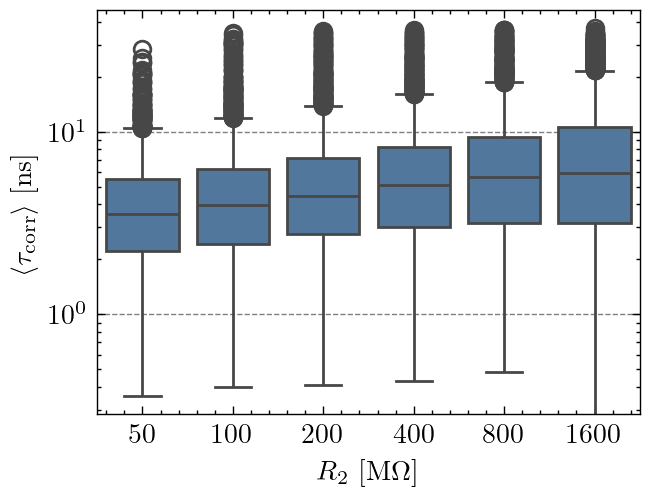

In [36]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.boxplot(taus_acf_df, x='R2', y='tau', color=BLUE_COLOR)
_       = ax.set_xlabel("$R_2$ [M$\Omega$]")
_       = ax.set_ylabel("$\\langle\\tau_\\textrm{corr}\\rangle$ [ns]")
_       = ax.set_yscale('log')

fig.savefig(f"plots/png/relaxation/charge_auto_tau_vs_R2.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/charge_auto_tau_vs_R2.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/charge_auto_tau_vs_R2.svg", transparent=True)

In [38]:
taus_acf_df.max()

tau      37.039363
R2     1600.000000
dtype: float64

### Potentials

In [31]:
taus_acf = {}
for MEAN_R2 in R_VALUES:
    taus_acf_l  = []
    for i in range(CPU_CNT):
        t_copy      = t.copy()[:-1]
        taus_acf_l2 = []
        for j in range(N_P*N_P):
            y_copy          = p_vals[MEAN_R2][i].copy()[:,j]/U0_VALUE
            _ , lags, acf   = analyze_steady_state_autocorrelation(t_copy, y_copy, -20000)
            tau             = get_tau_1_over_e(lags, acf)
            taus_acf_l2.append(tau*1e9)
        taus_acf_l.append(taus_acf_l2)
    taus_acf[MEAN_R2] = np.array(taus_acf_l)

taus_acf_dic = {MEAN_R2 : taus_acf[MEAN_R2].flatten() for MEAN_R2 in R_VALUES}
taus_acf_df = pd.DataFrame()
for MEAN_R2 in R_VALUES:
    df_tmp          = pd.DataFrame()
    df_tmp['tau']   = taus_acf_dic[MEAN_R2]
    df_tmp['R2']    = MEAN_R2
    taus_acf_df     = pd.concat([taus_acf_df, df_tmp], ignore_index=True)

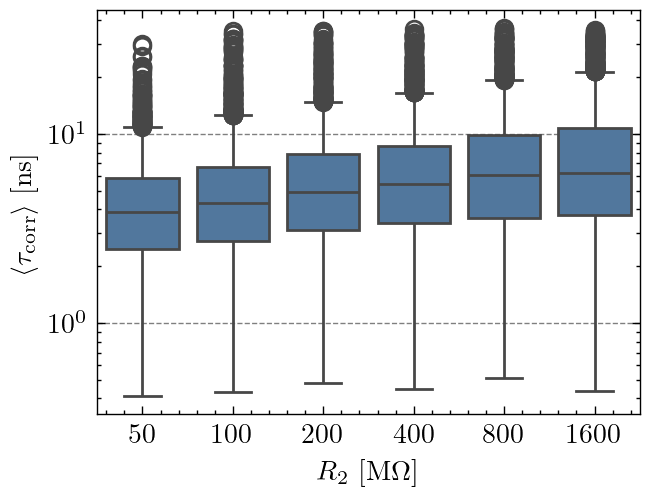

In [33]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.boxplot(taus_acf_df, x='R2', y='tau', color=BLUE_COLOR)
_       = ax.set_xlabel("$R_2$ [M$\Omega$]")
_       = ax.set_ylabel("$\\langle\\tau_\\textrm{corr}\\rangle$ [ns]")
_       = ax.set_yscale('log')

fig.savefig(f"plots/png/relaxation/pot_auto_tau_vs_R2.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/pot_auto_tau_vs_R2.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/pot_auto_tau_vs_R2.svg", transparent=True)

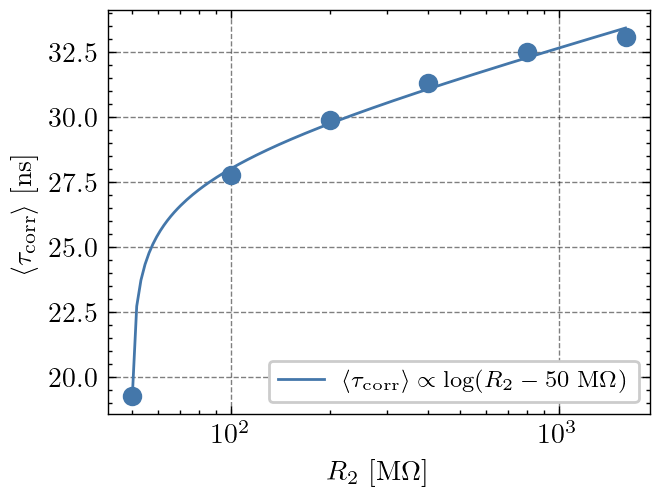

In [34]:
def model_func(x, a, b, c):
    return a + b * np.log(x - c)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
y   = [np.mean(np.sort(taus_acf_dic[MEAN_R2])[-32:]) for MEAN_R2 in R_VALUES]
x   = np.array(R_VALUES).copy()
x_v = np.linspace(x[0],x[-1],1000)
p,_ = curve_fit(model_func, x, y, bounds=((0,0,0),(np.inf,np.inf,50)))
pp  = ax.scatter(x, y)
_   = ax.plot(x_v, model_func(x_v, *p), label='$\\langle\\tau_\\textrm{corr}\\rangle \\propto \\log(R_2 - 50~\mathrm{M\Omega})$')
_   = ax.set_xlabel("$R_2$ [M$\Omega$]")
_   = ax.set_ylabel("$\\langle\\tau_\\textrm{corr}\\rangle$ [ns]")
_   = ax.set_xscale('log')
_   = ax.legend(fontsize='small', loc='lower right')

fig.savefig(f"plots/png/relaxation/auto_tau_scaling_R2.png", transparent=False)
fig.savefig(f"plots/pdf/relaxation/auto_tau_scaling_R2.pdf", transparent=False)
fig.savefig(f"plots/svg/relaxation/auto_tau_scaling_R2.svg", transparent=True)